In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from string import ascii_letters
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet
pd.set_option('display.max_columns',60)
import warnings
warnings.filterwarnings('ignore')

# Step 1: Define Helper Functions

In [2]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [3]:
def linkage_frame(data):
    row_clusters = linkage(data, method='complete', metric='euclidean')
    columns = ['row label 1', 'row label 2', 'distance', 'no. items in clust.']
    index = ['cluster %d' % (i + 1) for i in range(row_clusters.shape[0])]
    linkage_df = pd.DataFrame(row_clusters, columns=columns, index=index)
    return linkage_df

# Step 2: Load Dataset

In [5]:
path = './CitiBikeData/'

In [6]:
train_df = pd.read_csv(path + 'train.csv',index_col = 0)
test_df = pd.read_csv(path + 'test.csv',index_col = 0)

# Step 3: EDA

## Distribution of Target Variable (Hourly Checkout Counts for Start Stations)

In [5]:
train_df.start_station_checkout_counts.describe()

count    2.625091e+06
mean     1.363085e+01
std      1.514008e+01
min      1.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.700000e+01
max      3.070000e+02
Name: start_station_checkout_counts, dtype: float64

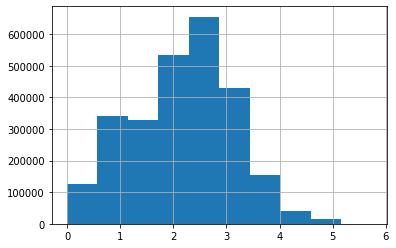

In [6]:
np.log(train_df.start_station_checkout_counts).hist()

- After a log transformation, the distribution of target varaible (hourly checkout counts for all start stations) follows a normal distribution 

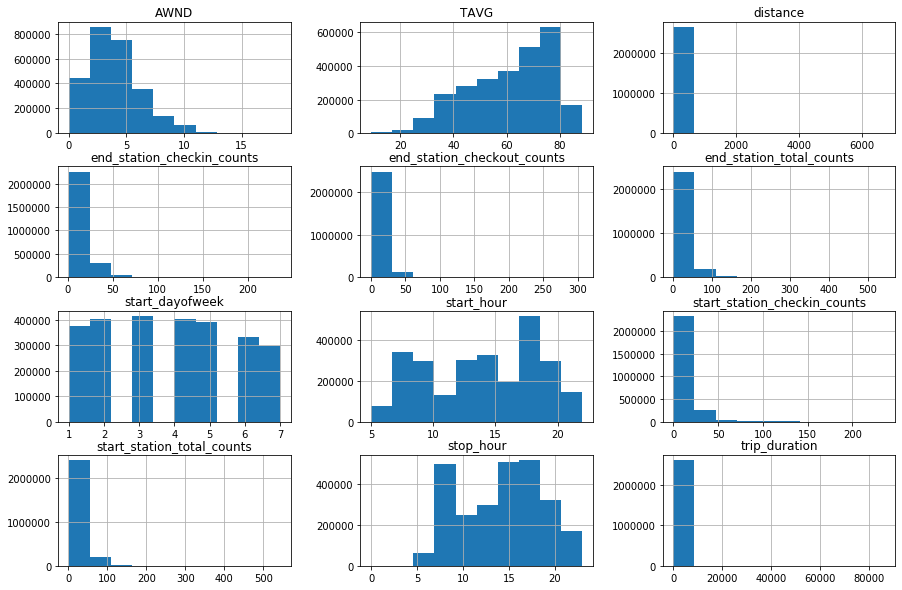

In [7]:
train_df[['trip_duration','start_dayofweek','start_hour','stop_hour','start_station_checkin_counts',\
          'start_station_total_counts','distance','end_station_checkin_counts','end_station_checkout_counts',\
         'end_station_total_counts','AWND','TAVG']].hist(figsize=(15,10));

- At a glance, a lot of features are highly right skewed.

## Seasonal Trend 

- Train Dataset

In [8]:
# Time Series of Trip Count
daily_trip = train_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')

- Test Dataset

In [9]:
daily_trip_test = test_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip_test.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip_test = daily_trip_test.groupby('Date').agg('mean').reset_index().set_index('Date')

### Time Series Plot of Daily Trip Counts, Average Trip Duration(s) and Average Distance (mile)

Text(0, 0.5, 'Avg Distance(mile)')

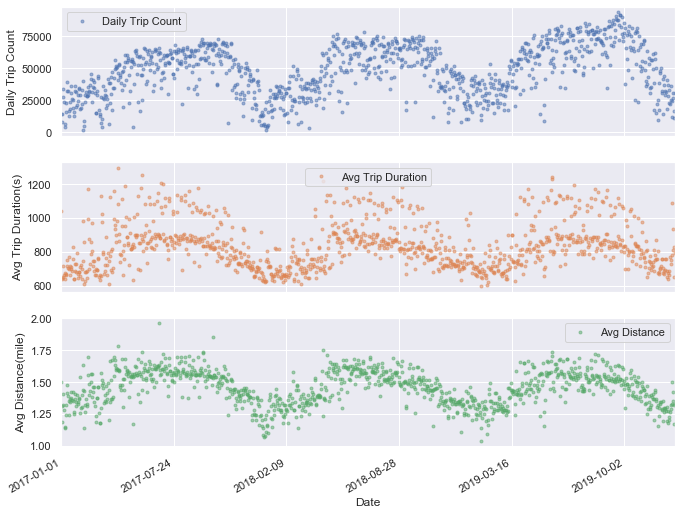

In [10]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Monthly Aaverage Trip Counts

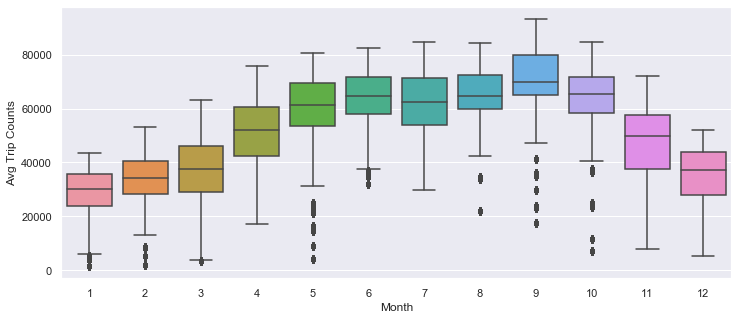

In [11]:
month_trip = train_df[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip);

### Monthly Average Trip Duration(s)

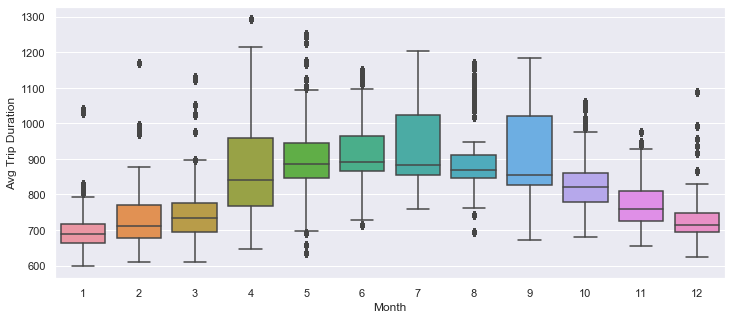

In [12]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip);

### Monthly Average Bike Distance(mile)

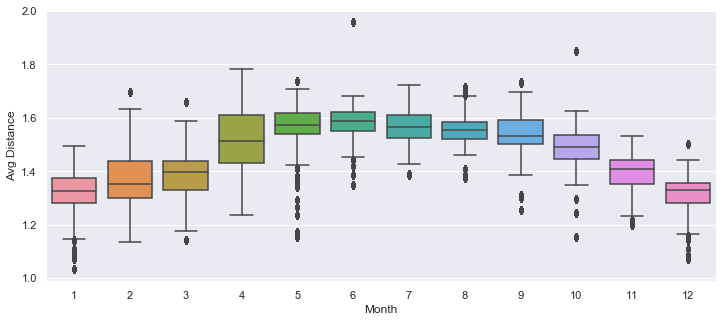

In [13]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Distance", data=month_trip);

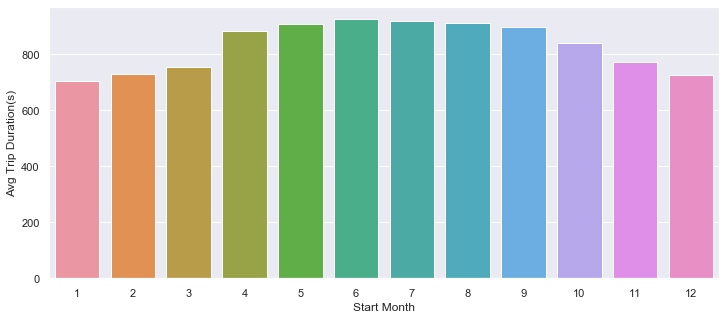

In [14]:
monthly_tripduration = train_df.groupby('start_month').mean()[['trip_duration']].reset_index()
monthly_tripduration.columns=['Start Month','Avg Trip Duration(s)']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month','Avg Trip Duration(s)', data = monthly_tripduration);

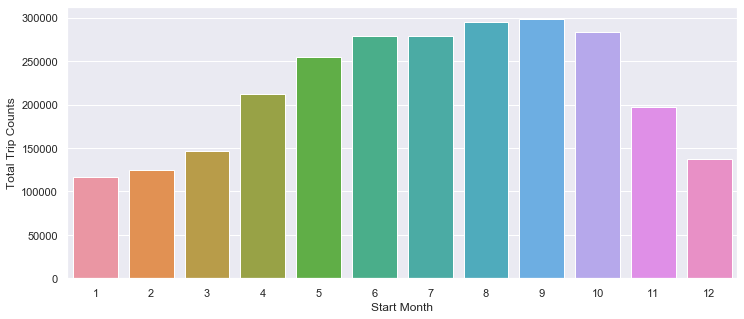

In [15]:
monthly_trip = train_df.groupby('start_month').count()[['trip_duration']].reset_index()
monthly_trip.columns=['Start Month','Total Trip Counts']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month', 'Total Trip Counts',data = monthly_trip);

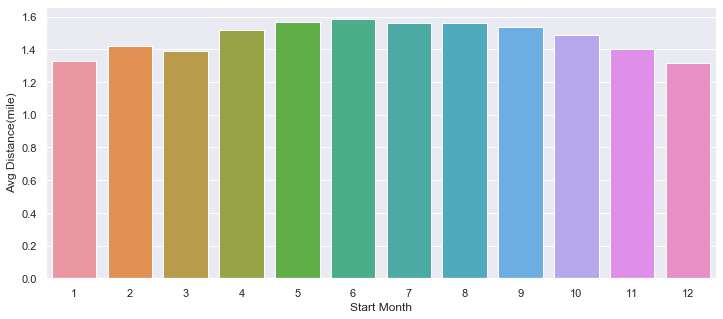

In [16]:
monthly_distance = train_df.groupby('start_month').mean()[['distance']].reset_index()
monthly_distance.columns=['Start Month','Avg Distance(mile)']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month','Avg Distance(mile)',data=monthly_distance);

## Weather Impact

### Temperature's impact on ride counts

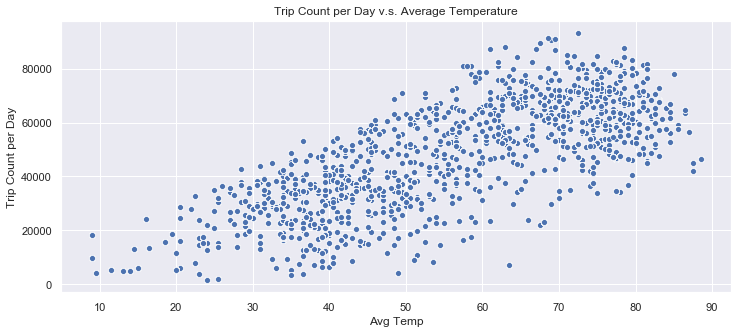

In [17]:
TEMP = train_df[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
TEMP.columns = ['Avg Temp','Avg Trip Duration(s)','Trip Count per Day','Avg Distance(mile)']
plt.figure(figsize=(12,5))
sns.scatterplot(x='Avg Temp',y='Trip Count per Day',data = TEMP).set(title = 'Trip Count per Day v.s. Average Temperature');

### Unusual Weather Conditions' impact on Ride Counts

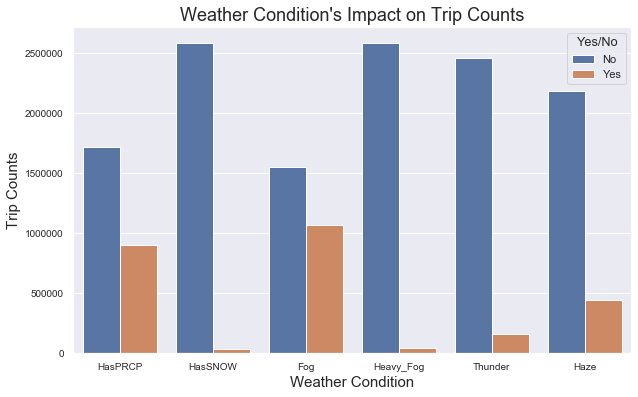

In [18]:
extreme_weather = train_df[['HasPRCP','HasSNOW','Fog', 'Heavy_Fog', 'Thunder', 'Haze']].apply(pd.value_counts)
extreme_weather= extreme_weather.unstack().reset_index()
extreme_weather.columns=['Weather Condition','Yes/No','Trip Counts']
extreme_weather['Yes/No']=['Yes' if x==1 else 'No' for x in extreme_weather['Yes/No']]
plt.figure(figsize=(10,6))
plt.rcParams["axes.labelsize"] = 15
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Weather Condition's Impact on Trip Counts", fontdict = {'fontsize' : 18})
sns.barplot(x='Weather Condition', y ='Trip Counts', hue ='Yes/No', data = extreme_weather);

## Number of stations in different years

In [19]:
train_df.loc[train_df.start_year == 2017].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2018].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2019].start_station_ID.nunique() 
train_df.start_station_ID.nunique()  
station_2017 = list(train_df.loc[train_df.start_year == 2017].start_station_ID.unique())
station_2018 = list(train_df.loc[train_df.start_year == 2018].start_station_ID.unique())
station_2019 = list(train_df.loc[train_df.start_year == 2019].start_station_ID.unique())
remove2018 =[item for item in station_2017 if item not in station_2018]
new2018 =[item for item in station_2018 if item not in station_2017]
remove2019 = [item for item in station_2018 if item not in station_2019]
new2019 =[item for item in station_2019 if item not in station_2018]
print('Number of stations removed in 2018: %.f' %len(remove2018))
print('Number of stations removed in 2019: %.f' %len(remove2019))
print('Number of stations added in 2018: %.f' %len(new2018))
print('Number of stations added in 2019: %.f' %len(new2019))

Number of stations removed in 2018: 40
Number of stations removed in 2019: 47
Number of stations added in 2018: 56
Number of stations added in 2019: 161


- 2017 has 799 unique stations, 2018 has 812 unique stations, and 2019 has 926 unique stations.
- Total unique stations for all three years are 1011 stations 

## Weekdays and Weekends

Text(0.5, 0, 'Is Weekday')

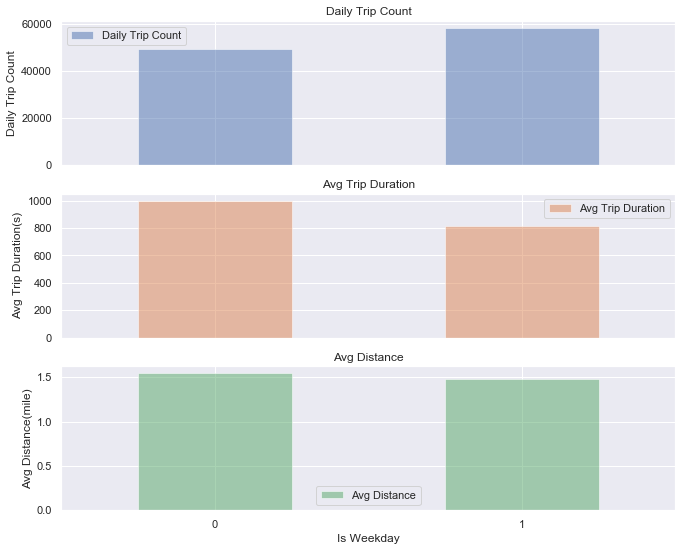

In [20]:
Weekday = train_df[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True,rot = 0);
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')
axes[2].set_xlabel('Is Weekday')

## Rush Hours

In [21]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,265637
18,252658
8,217400
16,193295
19,176047
9,172834


In [8]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df['Commute'] = np.where(((train_df['Isweekday']==1) &
                                        (train_df['start_hour'].isin(rushhours))),1,0)

In [9]:
test_df['Commute'] = np.where(((test_df['Isweekday']==1) &
                                        (test_df['start_hour'].isin(rushhours))),1,0)

## Top 50 Stations on Weekdays and Weekend

In [24]:
top50_weekdays = train_df.loc[train_df['Isweekday']==1].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

top50_weekends = train_df.loc[train_df['Isweekday']==0].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

In [25]:
# Merge Dataset and export csv for Tableau Visualization
top50_weekdays['Isweekday'] ='Weekday'
top50_weekends['Isweekday'] ='Weekend'
top50_all_days = pd.concat([top50_weekdays,top50_weekends],axis = 0).reset_index()
top50_all_days.columns=['Station Name','Trip Count','Latitude','Longitude','Isweekday']
top50_all_days.to_csv('Top50_All_Days.csv')

In [26]:
top50_all_days.head()

,Station Name,Trip Count,Latitude,Longitude,Isweekday
0,Pershing Square North,121.022568,40.751873,-73.977706,Weekday
1,E 47 St & Park Ave,77.285171,40.755103,-73.974987,Weekday
2,Broadway & E 22 St,75.111562,40.740343,-73.989551,Weekday
3,8 Ave & W 31 St,68.563875,40.750585,-73.994685,Weekday
4,West St & Chambers St,66.689360,40.717548,-74.013221,Weekday


In [27]:
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

- Weekends hotspots are shown as blue triangles. They are centered around central park, Hudson, West Village. 
- Weekdays hotspots are shown as red circiles. They are mostly in central Manhattan. 

## Top 50 start stations on weekdays during rush hours

In [28]:
top50_weekdays_rush_start = train_df.loc[train_df['Commute']==1].groupby(['start_station_name']).\
agg({'start_station_checkout_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_start['Isstart'] ='Start Station'
top50_weekdays_rush_start = top50_weekdays_rush_start.reset_index()
top50_weekdays_rush_start.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [29]:
# Top 50 end stations on weekdays during rush hours
top50_weekdays_rush_end = train_df.loc[train_df['Commute']==1].groupby(['end_station_name']).\
agg({'end_station_checkin_counts':'mean','end_station_latitude':'first', 'end_station_longitude':'first'}).\
sort_values(by = 'end_station_checkin_counts', ascending = False).head(50)
top50_weekdays_rush_end['Isstart'] = 'End Station'
top50_weekdays_rush_end.reset_index(inplace=True)
top50_weekdays_rush_end.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [30]:
# Merge Dataset and export csv for Tableau Visualization
top50_rushhours = pd.concat([top50_weekdays_rush_start,top50_weekdays_rush_end],axis = 0)
top50_rushhours.to_csv('Top50_Rushhours.csv')

In [31]:
top50_rushhours.head()

,Station Name,Trip Count,Latitude,Longitude,Isstart
0,Pershing Square North,82.790365,40.751873,-73.977706,Start Station
1,E 47 St & Park Ave,67.031753,40.755103,-73.974987,Start Station
2,Broadway & E 22 St,64.021218,40.740343,-73.989551,Start Station
3,Penn Station Valet - Valet Scan,57.203390,40.751284,-73.996925,Start Station
4,W 52 St & 6 Ave,56.646743,40.761330,-73.979820,Start Station


## Correlation Heat Map

In [32]:
columns =['start_station_latitude','start_station_longitude', 'start_year','start_month','start_dayofweek',\
          'start_station_checkout_counts','AWND', 'PRCP', 'SNOW',\
          'SNWD', 'TMAX','TMIN','TAVG','tot_docks']
corr =train_df[columns].corr()

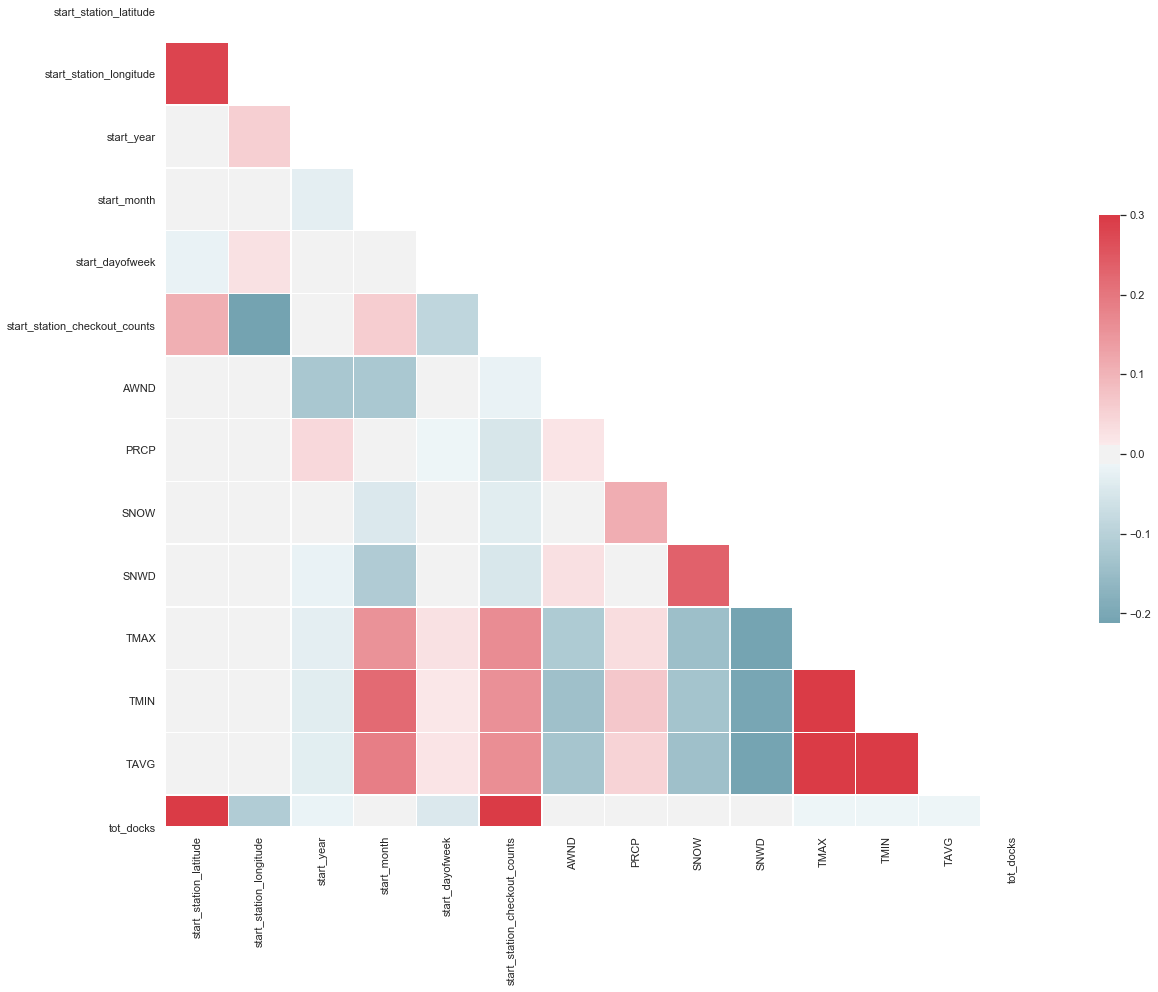

In [33]:
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## K-mean Clustering 
- Create clusters on dock stations based on location and usage, what else could be useful? 

In [10]:
train_df = train_df.loc[train_df.distance<200]
station = train_df.groupby(['start_station_name']).agg({'start_station_total_counts':'mean','Percent_usage':'mean',
                                                         'distance': 'mean'})

station.reset_index(inplace=True)

In [35]:
station = station.dropna(how = 'any')
station= station.loc[station.Percent_usage<5]
station.shape

(957, 4)

In [36]:
station.sample(10)

,start_station_name,start_station_total_counts,Percent_usage,distance
609,Knickerbocker Ave & Cooper St,1.625000,0.067708,2.168460
471,E 84 St & Park Ave,8.745137,0.194336,1.760429
414,E 44 St & 2 Ave,14.109611,0.361785,1.664021
423,E 51 St & 1 Ave,14.276425,0.407903,1.690339
74,31 Ave & 34 St,5.009558,0.217807,1.447914
893,W 15 St & 7 Ave,28.845896,0.738285,1.213163
939,W 50 St & 9 Ave,14.931298,0.497710,1.452339
300,Columbia St & Degraw St,6.636875,0.316042,1.325436
134,6 St & 7 Ave,4.374429,0.208306,1.272596
647,Liberty St & Broadway,25.129161,0.558426,1.584986


In [37]:
scaler = StandardScaler()
scaler.fit(station.iloc[:,1:])
station_scaled = scaler.transform(station.iloc[:,1:])
kmeans = KMeans()

In [38]:
station_scaled

array([[-5.52249418e-01, -4.34123094e-01,  1.45623488e-03],
       [ 1.49646318e+00,  9.77493353e-01, -8.33646250e-01],
       [ 9.03435495e-01,  7.24419763e-01, -7.62081374e-01],
       ...,
       [ 2.11795302e+00,  1.71733369e+00,  2.08558430e+00],
       [ 4.08516796e-01,  8.95832022e-01,  2.52960565e-02],
       [ 1.03112481e+00,  8.56882968e-01, -7.27999610e-01]])

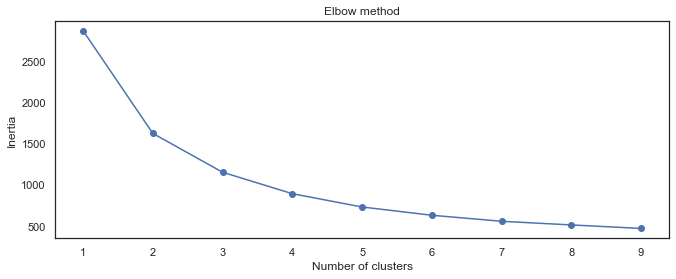

In [39]:
plot_inertia(kmeans, station_scaled, range(1, 10))

In [40]:
kmeans.set_params(n_clusters=4)
kmeans.fit(station_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
kmeans.cluster_centers_

array([[ 0.82185833,  0.80093643, -0.35414019],
       [ 2.55452491,  2.49219841,  0.13907182],
       [-0.54157891, -0.50781834, -0.33873224],
       [-0.54508985, -0.60001648,  1.66629751]])

In [42]:
#pd.concat([station,station_labels],axis=1)
station['cluster']= kmeans.labels_


In [43]:
station_geo = train_df.groupby('start_station_name')[['start_station_longitude','start_station_latitude']].apply(lambda x:x.iloc[0])
station_geo.reset_index(inplace=True)

In [44]:
cluster = station.merge(station_geo,how='left',on='start_station_name')

In [45]:
# cluster.to_csv('cluster.csv')

In [46]:
cluster = pd.read_csv('cluster.csv',index_col=0)

In [47]:
cluster.groupby('cluster').agg({'start_station_total_counts':'mean','Percent_usage':'mean','distance':'mean'})

,start_station_total_counts,Percent_usage,distance
cluster,,,
0,6.345607,0.200063,2.228039
1,22.568313,0.625371,1.424351
2,6.387274,0.228053,1.430480
3,43.131303,1.138812,1.620540


- **Cluster 3** are stations that have the highest activity among all other clusters. 
    - These stations are close by transit hubs (e.g. Grand Central, Penn Station, Port Authority) and major points of interest (e.g. Central Park)
    - Number of stations: 61
- **Cluster 1** are stations that have the second highest activity.
    - They are mostly located in central Manhattan.
    - Number of stations: 242
- **Cluster 2** are stations that have the lowest activity.
    - They are mostly located in upper East Side, Long Island city, Brooklyn.
    - Number of stations: 505
- **Cluster 0** are stations that have similar activity as cluster 0 (total checkin and checkout counts) but travel the furthest in distance.
    - They are mostly located in Upper West Side, Manhattan Valley, and Bushwick in Brooklyn. 
    - Number of stations: 149

In [48]:
cluster_reduced = cluster[['start_station_name','cluster']]
train_df = train_df.merge(cluster_reduced, how='left',on='start_station_name')
test_df = test_df.merge(cluster_reduced, how='left',on='start_station_name')

### Closer Look at Cluster 0: Low Activity and Long Distance

In [49]:
cluster0= train_df.loc[train_df['cluster']==0]
cluster0.distance.describe()

count    155460.000000
mean          2.152488
std           2.187828
min           0.095948
25%           0.849395
50%           1.704344
75%           2.902648
max         175.170436
Name: distance, dtype: float64

In [50]:
cluster0_dest = cluster0.groupby('end_station_name').agg({'trip_duration':'count',
                                        'end_station_longitude':'first',
                                       'end_station_latitude':'first',
                                       'distance':'mean'})
cluster0_dest = cluster0_dest.loc[cluster0_dest.trip_duration>200].drop(['trip_duration','distance'],axis=1).reset_index()
cluster0_dest.columns=['Station_name','Longitude','Latitude']
cluster0_dest['Isstart']='End Station'

In [51]:
cluster0_start=cluster0[['start_station_name','start_station_longitude','start_station_latitude']]
cluster0_start.columns=['Station_name','Longitude','Latitude']
cluster0_start['Isstart']='Start Station'
cluster0_start.drop_duplicates(inplace=True)

In [52]:
# pd.concat([cluster0_start,cluster0_dest]).to_csv('cluster0.csv')

### Closer Look at Cluster 2 : Lowest Activity and Short Distance

In [53]:
cluster2= train_df.loc[train_df['cluster']==2]
cluster2.distance.describe()

count    634713.000000
mean          1.445951
std           1.546727
min           0.034852
25%           0.609070
50%           1.045357
75%           1.861341
max         176.761049
Name: distance, dtype: float64

In [54]:
cluster2_dest = cluster2.groupby('end_station_name').agg({'trip_duration':'count',
                                        'end_station_longitude':'first',
                                       'end_station_latitude':'first',
                                       'distance':'mean'})
cluster2_dest = cluster2_dest.loc[cluster2_dest.trip_duration>500].drop(['trip_duration','distance'],axis=1).reset_index()
cluster2_dest.columns=['Station_name','Longitude','Latitude']
cluster2_dest['Isstart']='End Station'

In [55]:
cluster2_start=cluster2[['start_station_name','start_station_longitude','start_station_latitude']]
cluster2_start.columns=['Station_name','Longitude','Latitude']
cluster2_start['Isstart']='Start Station'
cluster2_start.drop_duplicates(inplace=True)

In [56]:
# pd.concat([cluster2_start,cluster2_dest]).to_csv('cluster2.csv')

### Net Hourly Change in Bikes For All Stations

In [7]:
# Net Change in bike: negative means more checkout than checkin, vice versa. 
cols = ['start_station_name','start_hour','start_station_checkin_counts','start_station_checkout_counts',\
        'start_station_longitude','start_station_latitude','tot_docks','cluster','Commute']
train_net = train_df[cols].copy()
# Only look at rush hours 
train_net = train_net.loc[train_net.Commute==1]
train_net['net_change'] = train_net['start_station_checkin_counts'] - train_net['start_station_checkout_counts']
# Normalize based on the capacity of each station 
train_net['net_change_percent'] =train_net['net_change']/train_net['tot_docks']

KeyError: "['Commute', 'cluster'] not in index"

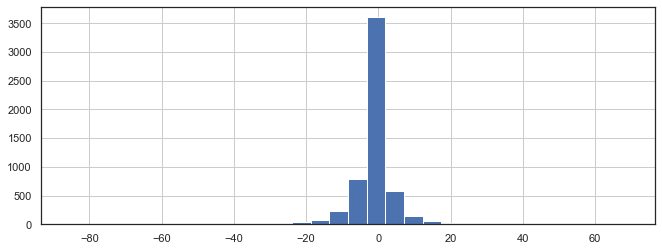

In [58]:
station_hourly_net = train_net.groupby(['start_station_name','start_hour']).\
agg({'net_change':'mean','net_change_percent':'mean',\
     'start_station_longitude':'first','start_station_latitude':'first'}).reset_index()

station_hourly_net.net_change.hist(bins=30);

In [59]:
low_threshold_percent = np.mean(station_hourly_net.net_change_percent) - 2*np.std(station_hourly_net.net_change_percent)
high_threshold_percent = np.mean(station_hourly_net.net_change_percent) + 2*np.std(station_hourly_net.net_change_percent)

In [60]:
neg_stations=station_hourly_net.loc[station_hourly_net.net_change_percent < low_threshold_percent].start_station_name.unique()

In [61]:
pos_stations = station_hourly_net.loc[station_hourly_net.net_change_percent > high_threshold_percent].start_station_name.unique()

In [62]:
High_neg = pd.DataFrame({'Station':neg_stations})
High_pos = pd.DataFrame({'Station':pos_stations})
Abnormal_stations = pd.concat([High_neg,High_pos])

In [63]:
station_activity = Abnormal_stations.merge(station_hourly_net,how='left',left_on='Station',right_on='start_station_name').drop('start_station_name',axis=1)
station_activity['Normality'] = ['Highly Negative' if x < low_threshold_percent else
                                 'Highly Positive' if x > high_threshold_percent else 'Normal' for x in station_activity['net_change_percent']]
station_activity.to_csv('station_activity.csv')

In [64]:
station_activity.net_change_percent.describe()

count    561.000000
mean      -0.086813
std        0.824362
min       -7.763605
25%       -0.432433
50%       -0.078915
75%        0.262329
max        4.142857
Name: net_change_percent, dtype: float64

### Hierarchical Clustering

In [65]:
# hier = AgglomerativeClustering()
# hier.set_params(n_clusters=4)
# hier.fit(station_scaled)

In [66]:
# station['cluster_hier']= hier.labels_

In [67]:
# cluster_hier = station.merge(station_geo,how='left',on='start_station_name')
# cluster_hier.sample(20)

In [68]:
# cluster_hier.groupby('cluster_hier').agg({'start_station_total_counts':'mean','Percent_usage':'mean','distance':'mean'})

In [69]:
# cluster_hier.to_csv('cluster_hier.csv')

In [70]:
# linkage_df = linkage_frame(station_scaled)

In [71]:
# row_dendr = dendrogram(linkage_df, leaf_rotation=90, truncate_mode='lastp',p = 10,leaf_font_size=8)
# plt.tight_layout()
# plt.ylabel('Euclidean distance')
# plt.show()

## Top 200 Dock Stations at All Times 

In [72]:
Top200_ID = list(train_df.groupby(['start_station_ID']).agg({'trip_duration':'count'}).\
sort_values(by='trip_duration',ascending=False).head(200).index)

In [73]:
Top200 = train_df.loc[train_df['start_station_ID'].isin(Top200_ID)]

In [74]:
Top200_test = test_df.loc[test_df['start_station_ID'].isin(Top200_ID)]

In [75]:
selected_cols=['start_station_latitude','start_station_longitude', 'start_hour',\
              'start_year','start_month','start_day','start_dayofweek','start_station_checkout_counts',\
              'start_station_checkin_counts','AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN', 'Fog',\
               'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze','TAVG','HasPRCP', 'HasSNOW',\
               'tot_docks', 'Percent_usage','Isweekday','holidays', 'Commute','cluster'] 
Top200 = Top200[selected_cols]
Top200_test = Top200_test[selected_cols]

In [76]:
Top200.drop_duplicates(inplace=True)
Top200_test.drop_duplicates(inplace=True)

In [77]:
Top200.to_csv('Top200_Stations.csv')
Top200_test.to_csv('Top200_test_Stations.csv')